In [19]:
#TFIDF Vectorizer for Tweet
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
# from sklearn.tree import DecisionTreeClassifier 

In [20]:
df=pd.read_csv("dataset/full.csv", encoding="utf-8")

In [21]:
del df["Unnamed: 0"]

In [22]:
# df['hashtag']

In [23]:
messages = df[['tweet','Categories']]

In [24]:
print(messages[:5])

                                               tweet Categories
0                                    #WelcomeBackHRS     Buzzer
1  Berita kepulangan sang Habib ini menjadi sanga...     Buzzer
2  @sohib212reborn Tagarnya #WelcomeBackIBHRS  #W...     Buzzer
3  Kesaksian Habib Rizieq  https://t.co/Ep6R7a4dO...     Buzzer
4                 #WelcomeBackHRS  #WelcomeHomeIBHRS     Buzzer


In [25]:
def split_into_tokens(message):
    message = message  # convert bytes into proper unicode
    return TextBlob(message).words

In [26]:
messages.tweet.apply(split_into_tokens)

0                                       [WelcomeBackHRS]
1      [Berita, kepulangan, sang, Habib, ini, menjadi...
2      [sohib212reborn, Tagarnya, WelcomeBackIBHRS, W...
3      [Kesaksian, Habib, Rizieq, https, t.co/Ep6R7a4...
4                     [WelcomeBackHRS, WelcomeHomeIBHRS]
                             ...                        
795      [Selamat, Datang, Kembali, HRS, WelcomeBackHRS]
796    [RomitsuT, Alhamdulillah, terimakasih, mas, pe...
797    [https, t.co/cqeEQfh7RL, Menyambut, Habib, Riz...
798    [Kenapa, di, trending, WelcomeBackHRS, dll, ny...
799    [Sudah, tak, ada, kata2, yg, sanggup, kami, Lo...
Name: tweet, Length: 800, dtype: object

In [27]:
def split_into_lemmas(message):
    message = message.lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

messages.tweet.apply(split_into_lemmas)

0                                       [welcomebackhrs]
1      [berita, kepulangan, sang, habib, ini, menjadi...
2      [sohib212reborn, tagarnya, welcomebackibhrs, w...
3      [kesaksian, habib, rizieq, http, t.co/ep6r7a4d...
4                     [welcomebackhrs, welcomehomeibhrs]
                             ...                        
795       [selamat, datang, kembali, hr, welcomebackhrs]
796    [romitsut, alhamdulillah, terimakasih, ma, per...
797    [http, t.co/cqeeqfh7rl, menyambut, habib, rizi...
798    [kenapa, di, trending, welcomebackhrs, dll, ny...
799    [sudah, tak, ada, kata2, yg, sanggup, kami, lo...
Name: tweet, Length: 800, dtype: object

In [17]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['tweet'])
print(len(bow_transformer.vocabulary_))
print(bow_transformer.get_feature_names()[:5])

3601
["'alaihi", "'alannabi", "'baik-baik", "'orangtua", "'real"]


In [79]:
messages_bow = bow_transformer.transform(messages['tweet'])
print('sparse matrix shape:', messages_bow.shape)
print('number of non-zeros:', messages_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

sparse matrix shape: (800, 3601)
number of non-zeros: 9125
sparsity: 0.32%


In [80]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [81]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(800, 3601)


In [82]:
%time spam_detector = MultinomialNB().fit(messages_tfidf, messages['Categories'])

Wall time: 8.98 ms


In [83]:
all_predictions = spam_detector.predict(messages_tfidf)

In [84]:
tr_acc = accuracy_score(messages['Categories'], all_predictions)
print("Accuracy on training set:  %.2f%%" % (100 * tr_acc))

Accuracy on training set:  98.00%


[Text(10.5, 0.5, 'Expected Value'), Text(0.5, 1.5, 'Predicted Value')]

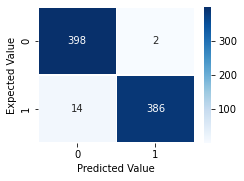

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(3.5,2.5))
sns.heatmap(confusion_matrix(messages['Categories'], all_predictions), annot=True, linewidths=.5, ax=ax, cmap="Blues", fmt="d").set(xlabel='Predicted Value', ylabel='Expected Value')

In [86]:
print(classification_report(messages['Categories'], all_predictions))

              precision    recall  f1-score   support

      Buzzer       0.97      0.99      0.98       400
         non       0.99      0.96      0.98       400

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800



In [87]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['tweet'], messages['Categories'], test_size=0.2, random_state=1)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

640 160 800


In [88]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [89]:
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         msg_train,  # training data
                         label_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores)

[0.921875 0.921875 0.984375 0.953125 0.90625  0.9375   0.875    0.921875
 0.890625 0.953125]


In [90]:
print('Mean score:', scores.mean(), '\n')
print('Stdev:', scores.std())

Mean score: 0.9265625 

Stdev: 0.030498783274911147


In [91]:
params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (split_into_lemmas, split_into_tokens),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(n_splits=5) # what type of cross validation to use
)

%time nb_detector = grid.fit(msg_train, label_train)
print(nb_detector.cv_results_)

Wall time: 3.84 s
{'mean_fit_time': array([0.6204175 , 0.60986943, 0.47801318, 0.49363313]), 'std_fit_time': array([0.01773236, 0.02586435, 0.0272374 , 0.01874466]), 'mean_score_time': array([0.16636705, 0.13454981, 0.11247196, 0.11248736]), 'std_score_time': array([0.01747309, 0.00613099, 0.01168896, 0.01167656]), 'param_bow__analyzer': masked_array(data=[<function split_into_lemmas at 0x00000136FFDD3790>,
                   <function split_into_lemmas at 0x00000136FFDD3790>,
                   <function split_into_tokens at 0x00000136FFBBD9D0>,
                   <function split_into_tokens at 0x00000136FFBBD9D0>],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'param_tfidf__use_idf': masked_array(data=[True, False, True, False],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'bow__analyzer': <function split_into_lemmas at 0x00000136FFDD3790>, 'tfidf__use_idf': True}, {'b

In [92]:
predictions = nb_detector.predict(msg_test)
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

      Buzzer       0.93      0.99      0.96        76
         non       0.99      0.93      0.96        84

    accuracy                           0.96       160
   macro avg       0.96      0.96      0.96       160
weighted avg       0.96      0.96      0.96       160



[Text(10.5, 0.5, 'Expected Value'), Text(0.5, 1.5, 'Predicted Value')]

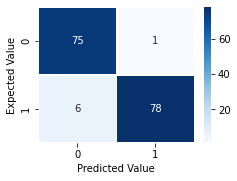

In [93]:
fig, ax = plt.subplots(figsize=(3.5,2.5))
sns.heatmap(confusion_matrix(label_test, predictions), annot=True, linewidths=.5, ax=ax, cmap="Blues", fmt="d").set(xlabel='Predicted Value', ylabel='Expected Value')


In [94]:
print("Accuracy on test set:  %.2f%%" % (100 * (nb_detector.cv_results_['mean_test_score'][0])))

Accuracy on test set:  92.81%


# New Data

In [56]:
data=pd.read_csv("tidak.csv")
data=data.iloc[:5]

In [58]:
data['tweet']

0    Bisa-bisanya temen gue presentasi typo jadi "t...
1    @HolmesTowns bagaimana jika mrs shampo pantine...
2    @jntexpressid Besok Checkout Pakai JNT  Alasan...
3    Cinta itu tidak selalu melekat pada kebersamaa...
4    Tuhan, maafkan kami yg tidak bisa menjaga titi...
Name: tweet, dtype: object

In [65]:
my_1st_tweet = 'Cinta itu tidak selalu melekat'
my_2nd_tweet = '@jejejk kamu kemana ulama Habib #WelcomeBackHRS'

In [63]:
print("Tweet #1:", "'",my_1st_tweet, "'", ' \n \n', "I'm about %.0f%%" % (100 * max(nb_detector.predict_proba([my_1st_tweet])[0])), "sure this was tweeted by", nb_detector.predict([my_1st_tweet])[0])

Tweet #1: ' Cinta itu tidak selalu melekat '  
 
 I'm about 80% sure this was tweeted by non


In [66]:
print("Tweet #2:", "'",my_2nd_tweet, "'", ' \n \n', "I'm about %.0f%%" % (100 * max(nb_detector.predict_proba([my_2nd_tweet])[0])), "sure this was tweeted by", nb_detector.predict([my_2nd_tweet])[0])

Tweet #2: ' @jejejk kamu kemana ulama Habib #WelcomeBackHRS '  
 
 I'm about 52% sure this was tweeted by Buzzer
